# Description:

* For emperical data, most taxa (>0.1% abundance) are detected across the entire gradient.
* Checking whether a similar pattern is seen with the simulated genome data

# Setting variables

In [36]:
workDir = '/home/nick/notebook/SIPSim/dev/bac_genome3/validation/'
R_dir = '/home/nick/notebook/SIPSim/lib/R/'
figDir = '/home/nick/notebook/SIPSim/figures/'

nprocs = 3

# Init

In [37]:
import os
import numpy as np
import dill
import pandas as pd
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [38]:
%%R
library(ggplot2)
library(plyr)
library(dplyr)
library(tidyr)
library(gridExtra)

In [39]:
if not os.path.isdir(workDir):
    os.makedirs(workDir)

## Determining the probability of detecting the taxa across the entire gradient

In [40]:
# max 13C shift
max_13C_shift_in_BD = 0.036
# min BD (that we care about)
min_GC = 13.5
min_BD = min_GC/100.0 * 0.098 + 1.66
# max BD (that we care about)
max_GC = 80
max_BD = max_GC / 100.0 * 0.098 + 1.66    # 80.0% G+C
max_BD = max_BD + max_13C_shift_in_BD
## BD range of values
BD_vals = np.arange(min_BD, max_BD, 0.001)

### skewed normal distribution

In [41]:
F = os.path.join(workDir, 'ampFrags_real_kde_dif.pkl')
with open(F, 'rb') as inFH:
    kde = dill.load(inFH)
kde

{'Clostridium_ljungdahlii_DSM_13528': <scipy.stats.kde.gaussian_kde at 0x7f5786a19a10>,
 'Escherichia_coli_1303': <scipy.stats.kde.gaussian_kde at 0x7f5786a0e690>,
 'Streptomyces_pratensis_ATCC_33331': <scipy.stats.kde.gaussian_kde at 0x7f5786a628d0>}

In [42]:
# probability at each location in gradient
pdf = {}
for k,v in kde.items():
    pdf[k] = v.evaluate(BD_vals)
pdf.keys()

['Clostridium_ljungdahlii_DSM_13528',
 'Escherichia_coli_1303',
 'Streptomyces_pratensis_ATCC_33331']

In [43]:
df = pd.DataFrame(pdf)
df['BD'] = BD_vals
df.head(n=3)

,Clostridium_ljungdahlii_DSM_13528,Escherichia_coli_1303,Streptomyces_pratensis_ATCC_33331,BD
0,8.416590e-21,4.434571e-19,9.193231e-184,1.67323
1,1.629729e-13,4.566996e-36,2.456874e-153,1.67423
2,3.311341e-08,1.178992e-36,1.018811e-125,1.67523


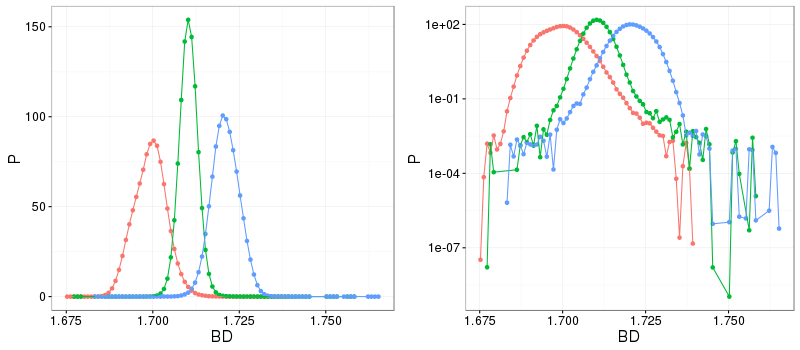

In [44]:
%%R -i df -w 800 -h 350

df.g = apply(df, 2, as.numeric) %>% as.data.frame %>%
    gather(taxon_name, P, 1:3) %>%
    mutate(BD = as.numeric(BD),
           P = as.numeric(P),
           taxon_name = as.character(taxon_name)) %>%
    filter(P > 1e-9)



p1 = ggplot(df.g, aes(BD, P, color=taxon_name)) +
    geom_point() +
    geom_line() +
    theme_bw() +
    theme(
        text = element_text(size=16),
        legend.position = 'none'
    )

p2 = p1 + scale_y_log10()

grid.arrange(p1, p2, ncol=2)

### small uniform distribution

In [45]:
F = os.path.join(workDir, 'ampFrags_sm_kde_dif.pkl')
with open(F, 'rb') as inFH:
    kde = dill.load(inFH)
kde

{'Clostridium_ljungdahlii_DSM_13528': <scipy.stats.kde.gaussian_kde at 0x7f57920002d0>,
 'Escherichia_coli_1303': <scipy.stats.kde.gaussian_kde at 0x7f5786a2ac50>,
 'Streptomyces_pratensis_ATCC_33331': <scipy.stats.kde.gaussian_kde at 0x7f5786775650>}

In [46]:
# probability at each location in gradient
pdf = {}
for k,v in kde.items():
    pdf[k] = v.evaluate(BD_vals)
pdf.keys()

['Clostridium_ljungdahlii_DSM_13528',
 'Escherichia_coli_1303',
 'Streptomyces_pratensis_ATCC_33331']

In [47]:
df = pd.DataFrame(pdf)
df['BD'] = BD_vals
df.head(n=3)

,Clostridium_ljungdahlii_DSM_13528,Escherichia_coli_1303,Streptomyces_pratensis_ATCC_33331,BD
0,7.857816e-09,1.369181e-86,1.211640e-210,1.67323
1,5.077048e-06,4.330080e-72,8.674757e-187,1.67423
2,2.742817e-04,5.570290e-59,2.156821e-164,1.67523


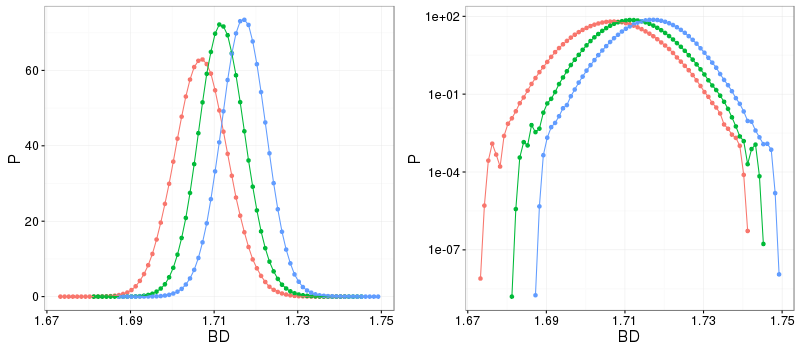

In [48]:
%%R -i df -w 800 -h 350

df.g = apply(df, 2, as.numeric) %>% as.data.frame %>%
    gather(taxon_name, P, 1:3) %>%
    mutate(BD = as.numeric(BD),
           P = as.numeric(P),
           taxon_name = as.character(taxon_name)) %>%
    filter(P > 1e-9)



p1 = ggplot(df.g, aes(BD, P, color=taxon_name)) +
    geom_point() +
    geom_line() +
    theme_bw() +
    theme(
        text = element_text(size=16),
        legend.position = 'none'
    )

p2 = p1 + scale_y_log10()

grid.arrange(p1, p2, ncol=2)

#### Notes

* Even with fragment sizes of 1-2 kb, the taxa would likely not be detected even if the gradient contained 1e9 16S copies of the taxon.
  * Does this make sense based on the theory of diffusion used?

# with DBL 'smearing'

## Determining the probability of detecting in all fragments

### skewed normal distribution

In [49]:
BD_vals = np.arange(min_BD, max_BD, 0.001)

In [50]:
F = os.path.join(workDir, 'ampFrags_real_kde_dif_DBL.pkl')
with open(F, 'rb') as inFH:
    kde = dill.load(inFH)
kde

{'Clostridium_ljungdahlii_DSM_13528': <scipy.stats.kde.gaussian_kde at 0x7f5786775890>,
 'Escherichia_coli_1303': <scipy.stats.kde.gaussian_kde at 0x7f5792000b50>,
 'Streptomyces_pratensis_ATCC_33331': <scipy.stats.kde.gaussian_kde at 0x7f57867750d0>}

In [51]:
# probability at each location in gradient
pdf = {}
for k,v in kde.items():
    pdf[k] = v.evaluate(BD_vals)
pdf.keys()

['Clostridium_ljungdahlii_DSM_13528',
 'Escherichia_coli_1303',
 'Streptomyces_pratensis_ATCC_33331']

In [52]:
df = pd.DataFrame(pdf)
df['BD'] = BD_vals
df.head(n=3)

,Clostridium_ljungdahlii_DSM_13528,Escherichia_coli_1303,Streptomyces_pratensis_ATCC_33331,BD
0,0.003620,0.013124,0.007160,1.67323
1,0.005044,0.007407,0.006324,1.67423
2,0.001189,0.009996,0.009634,1.67523


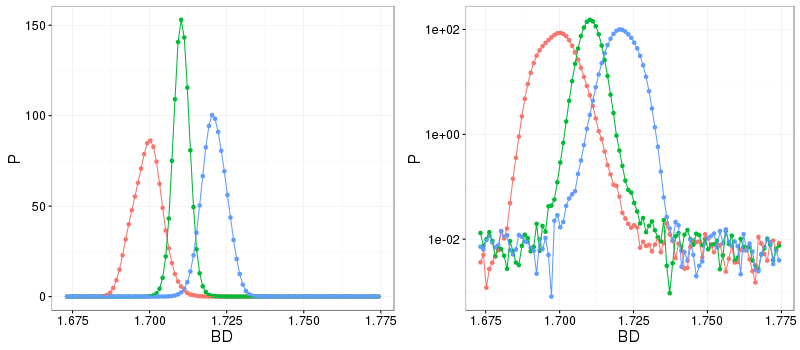

In [53]:
%%R -i df -w 800 -h 350

df.g = apply(df, 2, as.numeric) %>% as.data.frame %>%
    gather(taxon_name, P, 1:3) %>%
    mutate(BD = as.numeric(BD),
           P = as.numeric(P),
           taxon_name = as.character(taxon_name)) %>%
    filter(P > 1e-9)

p1 = ggplot(df.g, aes(BD, P, color=taxon_name)) +
    geom_point() +
    geom_line() +
    theme_bw() +
    theme(
        text = element_text(size=16),
        legend.position = 'none'
    )

p2 = p1 + scale_y_log10()

grid.arrange(p1, p2, ncol=2)

#### Notes

* Even if 1% of DNA is in DBL (that then diffuses back into the gradient):
  * the probably of detecting a taxa in all the gradient positions is >= 1e-7
    * this is feasible for matching the emperical data!

### small fragment size distribution

In [54]:
BD_vals = np.arange(min_BD, max_BD, 0.001)

In [55]:
F = os.path.join(workDir, 'ampFrags_sm_kde_dif_DBL.pkl')
with open(F, 'rb') as inFH:
    kde = dill.load(inFH)
kde

{'Clostridium_ljungdahlii_DSM_13528': <scipy.stats.kde.gaussian_kde at 0x7f5786775a90>,
 'Escherichia_coli_1303': <scipy.stats.kde.gaussian_kde at 0x7f5786a0e090>,
 'Streptomyces_pratensis_ATCC_33331': <scipy.stats.kde.gaussian_kde at 0x7f57867941d0>}

In [56]:
# probability at each location in gradient
pdf = {}
for k,v in kde.items():
    pdf[k] = v.evaluate(BD_vals)
pdf.keys()

['Clostridium_ljungdahlii_DSM_13528',
 'Escherichia_coli_1303',
 'Streptomyces_pratensis_ATCC_33331']

In [57]:
df = pd.DataFrame(pdf)
df['BD'] = BD_vals
df.head(n=3)

,Clostridium_ljungdahlii_DSM_13528,Escherichia_coli_1303,Streptomyces_pratensis_ATCC_33331,BD
0,0.003643,0.008033,0.008235,1.67323
1,0.004997,0.008003,0.007361,1.67423
2,0.008100,0.008035,0.007202,1.67523


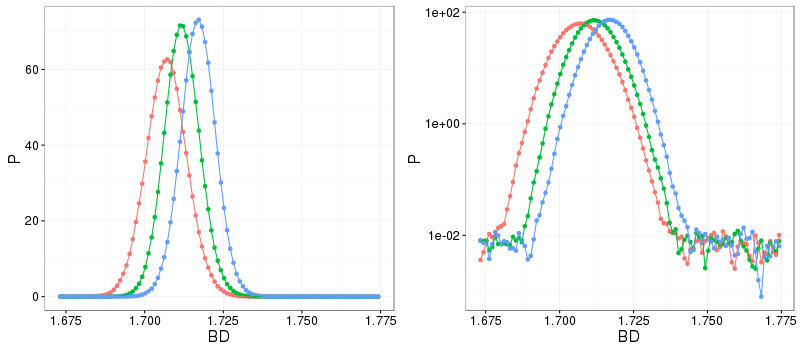

In [58]:
%%R -i df -w 800 -h 350

df.g = apply(df, 2, as.numeric) %>% as.data.frame %>%
    gather(taxon_name, P, 1:3) %>%
    mutate(BD = as.numeric(BD),
           P = as.numeric(P),
           taxon_name = as.character(taxon_name)) %>%
    filter(P > 1e-9)

p1 = ggplot(df.g, aes(BD, P, color=taxon_name)) +
    geom_point() +
    geom_line() +
    theme_bw() +
    theme(
        text = element_text(size=16),
        legend.position = 'none'
    )

p2 = p1 + scale_y_log10()

grid.arrange(p1, p2, ncol=2)

# with DBL 'smearing' (smaller DBL)

## Determining the probability of detecting in all fragments

### skewed normal distribution

In [59]:
BD_vals = np.arange(min_BD, max_BD, 0.001)

In [60]:
F = os.path.join(workDir, 'ampFrags_real_kde_dif_DBL_fa1e-4.pkl')
with open(F, 'rb') as inFH:
    kde = dill.load(inFH)
kde

{'Clostridium_ljungdahlii_DSM_13528': <scipy.stats.kde.gaussian_kde at 0x7f5786775690>,
 'Escherichia_coli_1303': <scipy.stats.kde.gaussian_kde at 0x7f5786775f90>,
 'Streptomyces_pratensis_ATCC_33331': <scipy.stats.kde.gaussian_kde at 0x7f5786775c90>}

In [61]:
# probability at each location in gradient
pdf = {}
for k,v in kde.items():
    pdf[k] = v.evaluate(BD_vals)
pdf.keys()

['Clostridium_ljungdahlii_DSM_13528',
 'Escherichia_coli_1303',
 'Streptomyces_pratensis_ATCC_33331']

In [62]:
df = pd.DataFrame(pdf)
df['BD'] = BD_vals
df.head(n=3)

,Clostridium_ljungdahlii_DSM_13528,Escherichia_coli_1303,Streptomyces_pratensis_ATCC_33331,BD
0,1.631444e-06,0.000375,0.000216,1.67323
1,5.361316e-07,0.001505,0.001849,1.67423
2,3.456207e-04,0.002166,0.000028,1.67523


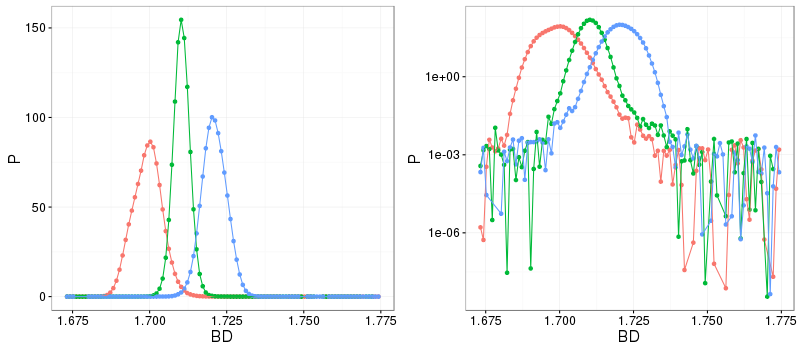

In [63]:
%%R -i df -w 800 -h 350

df.g = apply(df, 2, as.numeric) %>% as.data.frame %>%
    gather(taxon_name, P, 1:3) %>%
    mutate(BD = as.numeric(BD),
           P = as.numeric(P),
           taxon_name = as.character(taxon_name)) %>%
    filter(P > 1e-9)

p1 = ggplot(df.g, aes(BD, P, color=taxon_name)) +
    geom_point() +
    geom_line() +
    theme_bw() +
    theme(
        text = element_text(size=16),
        legend.position = 'none'
    )

p2 = p1 + scale_y_log10()

grid.arrange(p1, p2, ncol=2)